In [1]:
import numpy as np
import pandas as pd
import math
import statistics as stat
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

In [2]:
#loading datasets
ratings = pd.read_csv("/Volumes/bp first/Tampere University/Recommender Systems/ml-100k/userdata.csv", sep='\t', header=None)
ratings.columns=['userId','movieId','rating','timestamp']

d = 'movieId | title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')

# Loading the movies dataset
movies_data = pd.read_csv('/Volumes/bp first/Tampere University/Recommender Systems/ml-100k/uitem.csv', sep='|',header=None,names=column_names2,encoding='latin-1')
movies=movies_data[['movieId','title']]
movies

,movieId,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [3]:
##Dropping the column "Timestamp" from the ratings
ratings = ratings.drop(columns = ["timestamp"])

In [4]:
## Takes UserId and creates a User Matrix
def create_userX_matrix(userId):
    userX_matrix = ratings.query('userId == @userId',inplace = False)
    return userX_matrix
## Creates a user subset where one groups by userID which will be taken into consideration for calculating 
## pearson correlation and find out the most similar users.
def user_subset_common_movie(userId):
    userX_matrix = create_userX_matrix(userId)
    users = ratings[ratings['movieId'].isin(userX_matrix['movieId'].tolist())]
    userSubsetGroup = users.groupby(['userId'])
    userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]) and len(x[1]) > 50, reverse=True)
    return userSubsetGroup, userX_matrix
## Function for calculating the Pearson Correlation Function
def pearsonCorr(inputMovies, similarUsersGroup):
    pearsonCorrelationDict = {}
    for name, group in similarUsersGroup:
        group = group.sort_values(by='movieId')
        inputMovies1 = inputMovies.sort_values(by='movieId')
        temp_df = inputMovies1[inputMovies1['movieId'].isin(group['movieId'].tolist())]
        selectedUserTempRatingList = temp_df['rating'].tolist()
        similarUserTempRatingList = group['rating'].tolist()

        simXX = 0
        meanSelectedUserTempRating = stat.mean(selectedUserTempRatingList)
        for i in selectedUserTempRatingList:
            simXX = simXX + pow((i - meanSelectedUserTempRating),2)
        simYY = 0
        meanSimilarUserTempRaning = stat.mean(similarUserTempRatingList)
        for j in similarUserTempRatingList:
            simYY = simYY + pow((j - meanSimilarUserTempRaning),2)
        simXY = 0
        for i, j in zip(selectedUserTempRatingList, similarUserTempRatingList):
            simXY = simXY+ ((i - meanSelectedUserTempRating ) * (j-meanSimilarUserTempRaning))

        if simXX != 0 and simYY != 0:
            pearsonCorrelationDict[name] = simXY/np.sqrt(simXX*simYY)
        else:
            pearsonCorrelationDict[name] = 0                    
    
    maxSimilarUser = dict(sorted(pearsonCorrelationDict.items(), key=lambda item: item[1], reverse= True))
    return maxSimilarUser

In [5]:
## Function for producing Recommendations for the specific User
def produceRec (inputMovies, pearsonCorrelationDict):
    similarityScoreofSimilarUsers_data = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
    similarityScoreofSimilarUsers_data.head()
    similarityScoreofSimilarUsers_data.columns = ['similarityScore']
    similarityScoreofSimilarUsers_data['userId'] = similarityScoreofSimilarUsers_data.index
    similarityScoreofSimilarUsers_data.index = range(len(similarityScoreofSimilarUsers_data))
    topSimilarUsers=similarityScoreofSimilarUsers_data.sort_values(by='similarityScore', ascending=False)
    topSimilarUsersRating = topSimilarUsers.merge(ratings, left_on='userId', right_on='userId', how='inner')
    topSimilarUsersRating.head()
    meanRb = topSimilarUsersRating.groupby('userId').mean()[['rating']]
    meanRb.columns = ['avgRating']
    meanRb['userId'] = meanRb.index
    meanRb.index = range(len(meanRb))
    topSimilarUsersRating = topSimilarUsersRating.merge(meanRb, left_on='userId', right_on='userId', how='inner')
    topSimilarUsersRating['weightedRatingScore'] = topSimilarUsersRating['similarityScore']*(topSimilarUsersRating['rating']-topSimilarUsersRating['avgRating'])
    tempTopSimilarUsersRating = topSimilarUsersRating.groupby('movieId').sum()[['weightedRatingScore']]
    tempTopSimilarUsersRating.columns = ['sum_weightedRatingScore']
    tempTopSimilarUsersRating['movieId'] = tempTopSimilarUsersRating.index
    

    recommendation_data = pd.DataFrame()
    meanRa = inputMovies['rating'].mean()
    recommendation_data['weighted average recommendation score'] = meanRa+(tempTopSimilarUsersRating['sum_weightedRatingScore']/topSimilarUsers['similarityScore'].sum())
    recommendation_data['movieId'] = recommendation_data.index
    recommendation_data = recommendation_data.sort_values(by='weighted average recommendation score', ascending=False)
    recommendation_data.index = [x for x in range(1,len(recommendation_data)+1)]
    recommendation_data = recommendation_data.rename(columns=  {'weighted average recommendation score': 'scores'})
    return recommendation_data

In [6]:
## The main agenda is to deal with groups and generate sequential recommendations 
## by performing several iterations.
## In this code, specifically 5 Iterations are generated as per the instructions in the assignment

In [7]:
## Firstly, a random user has been with userId = 15
## Followed by finding the pearson correlation matrix and then finding two other random similar users with userId = 15
## userB = 134 & userC = 384

In [8]:
#UserA = 15 --> Taken Randomly 
userA = 472
userSubsetGroupA, userAMatrix = user_subset_common_movie(userA)
pearsonCorrelationDictA = pearsonCorr(userAMatrix, userSubsetGroupA)
recMovieA = produceRec(userAMatrix, pearsonCorrelationDictA)
userAMatrix

,userId,movieId,rating
20576,472,401,4
20621,472,11,5
20709,472,193,5
20763,472,877,3
20826,472,258,5
...,...,...,...
94424,472,356,3
95959,472,1029,4
96115,472,549,5
98382,472,96,5


In [9]:
pearsonCorrelationDictA

{472: 1.0,
 34: 1.0,
 732: 1.0,
 36: 0.9622504486493763,
 266: 0.9449111825230682,
 547: 0.9444444444444444,
 146: 0.9428090415820635,
 884: 0.9428090415820635,
 611: 0.9271726499455306,
 440: 0.8846517369293828,
 86: 0.8660254037844385,
 415: 0.857492925712544,
 149: 0.8528028654224413,
 725: 0.8284941842352037,
 809: 0.8164965809277261,
 572: 0.816496580927726,
 134: 0.7999999999999999,
 937: 0.7985836518841365,
 126: 0.7919840945184121,
 438: 0.7794488346453277,
 485: 0.7745966692414834,
 520: 0.7745966692414834,
 491: 0.768273325346536,
 284: 0.7559289460184544,
 859: 0.7555521205625413,
 509: 0.7516460280028288,
 631: 0.7454993164109749,
 300: 0.7319250547114,
 813: 0.7319250547113999,
 743: 0.7258661863112977,
 51: 0.7253367960171441,
 143: 0.7024393586862706,
 752: 0.7001400420140045,
 556: 0.6846531968814576,
 205: 0.6666666666666665,
 800: 0.6499999999999998,
 129: 0.6324555320336758,
 641: 0.625,
 549: 0.6109197266035429,
 742: 0.6085478976526293,
 350: 0.5965048272039514,
 7

In [10]:
userB = 34
userSubsetGroupB, userBMatrix = user_subset_common_movie(userB)
pearsonCorrelationDictB = pearsonCorr(userBMatrix, userSubsetGroupB)
recMovieB = produceRec(userBMatrix, pearsonCorrelationDictB)

userC = 732
#userC = 384
userSubsetGroupC, userCMatrix = user_subset_common_movie(userC)
pearsonCorrelationDictC = pearsonCorr(userCMatrix, userSubsetGroupC)
recMovieC = produceRec(userCMatrix, pearsonCorrelationDictC)

In [11]:
# First iteration
# For the first iteration, we will do the same approach as previous assignment on group recommendation using average and least misery aggregation method.
# The group recommendation from this stage will be used as a starting point for the next iterations

In [12]:
aL = recMovieA['movieId'].tolist()
bL = recMovieB['movieId'].tolist()
cL = recMovieC['movieId'].tolist()

## Finding out the common movies between UserA, UserB and UserC
commonRecMov = set(aL) & set(bL) & set(cL)

## Fetching the movies from the recommendation List which are found in the common recommendation of the movies
recA = recMovieA[recMovieA['movieId'].isin(commonRecMov)]
recB = recMovieB[recMovieB['movieId'].isin(commonRecMov)]
recC = recMovieC[recMovieC['movieId'].isin(commonRecMov)]

# Averaging the three user's recommendation with averaging method
frames = [recA, recB, recC]
result = pd.concat(frames)
GrAv = result.groupby(['movieId'], as_index= False).mean().sort_values(by='scores', ascending=False)
GrAv.index = [x for x in range(1, len(GrAv)+1)]
GrAv['title'] = GrAv['movieId'].map(movies['title'])

# GrAv = GrAv.rename(columns=  {'ratings': 'average_rating'})
top20Av1 = GrAv.head(20)
list20Av1Mov = top20Av1['movieId'].tolist()
top20Av1

#showing the top 20 reccommended movie for average method                           
                           

,movieId,scores,title
1,286,4.809892,Marvin's Room (1996)
2,100,4.474815,Heavy Metal (1981)
3,50,4.419415,Legends of the Fall (1994)
4,127,4.414555,Supercop (1992)
5,318,4.369519,Everyone Says I Love You (1996)
6,64,4.315701,What's Eating Gilbert Grape (1993)
7,302,4.306032,Ulee's Gold (1997)
8,269,4.289474,Gattaca (1997)
9,483,4.266457,"Maltese Falcon, The (1941)"
10,313,4.253200,3 Ninjas: High Noon At Mega Mountain (1998)


In [13]:
## Calculation of the alpha score:- Taking the paper method and few personal modifications
def alpha_score(userARec, userBRec, userCRec, GroupRec):
    
    list20Mov = GroupRec['movieId'].tolist()
    
    ## Making three individual lists and finding out the movies that are present in list20MOv
    userAList = userARec[userARec['movieId'].isin(list20Mov)]['movieId'].tolist()
    userBList = userBRec[userBRec['movieId'].isin(list20Mov)]['movieId'].tolist()
    userCList = userCRec[userCRec['movieId'].isin(list20Mov)]['movieId'].tolist()
        
    ## Calculating the satisfaction score for every user
    satUserA = np.sum(GroupRec['scores'])/np.sum(userARec[userARec['movieId'].isin(list20Mov)]['scores'])
    satUserB = np.sum(GroupRec['scores'])/np.sum(userBRec[userBRec['movieId'].isin(list20Mov)]['scores'])
    satUserC = np.sum(GroupRec['scores'])/np.sum(userCRec[userCRec['movieId'].isin(list20Mov)]['scores'])
    satUsersList = [satUserA, satUserB, satUserC]
    
    ## Calculating the Group Satisfaction Score
    group_sat = np.mean(satUsersList)
    #group_dis = np.max(satUsersList) - np.min(satUsersList)
    
    ## Kendall Tau between the users so as to find out the disagreement among the users  
    ## This will help us to understand that how disagreements among the users affect the overall satisfaction
    ktAB, p_valAB = kendalltau(userAList, userBList)
    ktBC, p_valBC = kendalltau(userBList, userCList)
    ktAC, p_valAC = kendalltau(userAList, userCList)
    
    ## Kendall Tau between the userAList and the list20Mov
    ktAG, p_valAG = kendalltau(userAList, list20Mov)
    ktBG, p_valBG = kendalltau(userBList, list20Mov)
    ktCG, p_valCG = kendalltau(userCList, list20Mov)
    
    ## Calculating the means for two scenarios ;- among users, between user individual list and generated movie list
    ktOnlyUsers = np.mean([ktAB, ktBC, ktAC])
    ktOverall = np.mean([ktAG, ktBG, ktCG])
    
    ## Difference of the result of two scenarios
    alpha = abs(ktOnlyUsers - ktOverall)
    
    print(f'User A sat.Score: {satUserA}')
    print(f'User B sat.Score: {satUserB}')
    print(f'User C sat.Score: {satUserC}')
    print(f'Group disagreement: {alpha}')
    print(f'Group disagreement amoung Users: {ktOnlyUsers}')
    print(f'Group disagreement overall: {ktOverall}')

    return satUserA, satUserB, satUserC, alpha, group_sat
    

In [14]:
def sequential_hybrid(recAdf, recBdf, recCdf, alpha, prevIter):
    
    #Not considering the movies that have been recommended on the previous iteration
    prevIterMov = prevIter['movieId'].tolist()    
    recAdf = recAdf[~recAdf['movieId'].isin(prevIterMov)]
    recBdf = recBdf[~recBdf['movieId'].isin(prevIterMov)]
    recCdf = recCdf[~recCdf['movieId'].isin(prevIterMov)]
    frames = [recAdf, recBdf, recCdf]

    results = pd.concat(frames)
    GrIterJAv = results.groupby(['movieId'], as_index= False).mean().sort_values(by='scores', ascending=False)
    GrIterJAv['scores'] = GrIterJAv['scores']*(1-alpha)
    GrIterJLM = result.groupby(['movieId'], as_index= False).min().sort_values(by='scores', ascending=False)
    GrIterJLM['scores'] = GrIterJLM['scores']*(alpha)
    
    frames = [GrIterJAv, GrIterJLM]
    comb = pd.concat(frames)
    GrIterJ = comb.groupby(['movieId'], as_index= False).sum().sort_values(by='scores', ascending=False)
    GrIterJ['title'] = GrIterJ['movieId'].map(movies['title'])
    
    
    return recAdf, recBdf, recCdf, GrIterJ

In [15]:
#get satisfaction score of thre previous iteration
satA1, satB1, satC1, alpha1, group_sat1= alpha_score(recA, recB, recC, top20Av1)

User A sat.Score: 0.9616003989950417
User B sat.Score: 0.979315771848876
User C sat.Score: 1.0650241036803505
Group disagreement: 0.024561403508771933
Group disagreement amoung Users: -0.024561403508771933
Group disagreement overall: -0.04912280701754387


In [16]:
# Make new recommendation based on the previous satisfaction score
# and new users personal recommendation which deletes all movies that have been
# previously recommended

In [17]:
#Second Iteration
recA2, recB2, recC2, GRiter2 = sequential_hybrid(recA, recB, recC, alpha1, top20Av1)
GRiter2Top20 = GRiter2.head(20)
GRiter2Top20

,movieId,scores,title
196,197,4.185403,Nikita (La Femme Nikita) (1990)
257,258,4.182239,George of the Jungle (1997)
514,515,4.179414,Local Hero (1983)
134,135,4.177121,Mr. Smith Goes to Washington (1939)
55,56,4.175799,Priest (1994)
8,9,4.174717,Richard III (1995)
473,474,4.173231,Trainspotting (1996)
426,427,4.172067,Harold and Maude (1971)
602,603,4.164934,It Happened One Night (1934)
198,199,4.155314,"Shining, The (1980)"


In [18]:
#Third Iteration
satA2, satB2, satC2, alpha2, group_sat2 = alpha_score(recA2, recB2, recC2, GRiter2Top20)
recA3, recB3, recC3, GRiter3 = sequential_hybrid(recA2, recB2, recC2, alpha2, GRiter2Top20)
GRiter3Top20 = GRiter3.head(20)
GRiter3Top20

User A sat.Score: 0.9562163431794336
User B sat.Score: 0.9741075294730202
User C sat.Score: 1.072140437913866
Group disagreement: 0.02105263157894737
Group disagreement amoung Users: -0.024561403508771933
Group disagreement overall: -0.003508771929824562


,movieId,scores,title
186,187,4.138343,Full Metal Jacket (1987)
241,242,4.132011,Jungle2Jungle (1997)
174,175,4.131849,Aliens (1986)
689,690,4.127888,Dark City (1998)
222,223,4.125300,Ridicule (1996)
68,69,4.124646,Four Weddings and a Funeral (1994)
527,528,4.124215,My Life as a Dog (Mitt liv som hund) (1985)
131,132,4.122548,Gone with the Wind (1939)
478,479,4.121041,North by Northwest (1959)
177,178,4.120186,"Clockwork Orange, A (1971)"


In [19]:
#Fourth Iteration
satA3, satB3, satC3, alpha3, group_sat3 = alpha_score(recA3, recB3, recC3, GRiter3Top20)
recA4, recB4, recC4, GRiter4 = sequential_hybrid(recA3, recB3, recC3, alpha3, GRiter3Top20)
GRiter4Top20 = GRiter4.head(20)
GRiter4Top20

User A sat.Score: 0.952479235499667
User B sat.Score: 0.9801309716839653
User C sat.Score: 1.0705619504510435
Group disagreement: 0.12631578947368421
Group disagreement amoung Users: -0.10877192982456141
Group disagreement overall: 0.017543859649122806


,movieId,scores,title
495,496,4.073934,Bringing Up Baby (1938)
331,332,4.071838,"Game, The (1997)"
215,216,4.070654,Bram Stoker's Dracula (1992)
210,211,4.070010,"Unbearable Lightness of Being, The (1988)"
192,193,4.069468,"Sting, The (1973)"
204,205,4.068997,Akira (1988)
650,651,4.068592,Rosencrantz and Guildenstern Are Dead (1990)
749,750,4.067049,Tomorrow Never Dies (1997)
21,22,4.063622,Taxi Driver (1976)
180,181,4.063412,GoodFellas (1990)


In [20]:
#Fifth Iteration
satA4, satB4, satC4, alpha4, group_sat4 = alpha_score(recA4, recB4, recC4, GRiter4Top20)
recA5, recB5, recC5, GRiter5 = sequential_hybrid(recA4, recB4, recC4, alpha4, GRiter4Top20)
GRiter5Top20 = GRiter5.head(20)
GRiter5Top20

User A sat.Score: 0.9417083207740368
User B sat.Score: 0.9777644392553018
User C sat.Score: 1.062739266654549
Group disagreement: 0.07017543859649124
Group disagreement amoung Users: 0.0736842105263158
Group disagreement overall: 0.003508771929824563


,movieId,scores,title
314,315,4.068659,As Good As It Gets (1997)
497,498,4.068432,Cat on a Hot Tin Roof (1958)
191,192,4.067125,"Right Stuff, The (1983)"
658,659,4.065015,Fried Green Tomatoes (1991)
172,173,4.064776,Raiders of the Lost Ark (1981)
58,59,4.064484,Three Colors: Blue (1993)
483,484,4.064250,My Fair Lady (1964)
508,509,4.061870,"Magnificent Seven, The (1954)"
27,28,4.059682,Batman Forever (1995)
581,582,4.058907,Romeo Is Bleeding (1993)


In [21]:
satA5, satB5, satC5, alpha5, group_sat5 = alpha_score(recA5, recB5, recC5, GRiter5Top20)

User A sat.Score: 0.9436342427943327
User B sat.Score: 0.9804587948828474
User C sat.Score: 1.0694686571513319
Group disagreement: 0.0736842105263158
Group disagreement amoung Users: 0.03157894736842106
Group disagreement overall: 0.10526315789473685


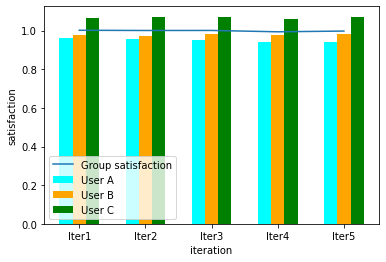

<Figure size 2400x1600 with 0 Axes>

In [22]:
labels = ['Iter1', 'Iter2', 'Iter3', 'Iter4', 'Iter5']
x = np.arange(len(labels))
userASatL = [satA1, satA2, satA3, satA4, satA5]
userBSatL = [satB1, satB2, satB3, satB4, satB5]
userCSatL = [satC1, satC2, satC3, satC4, satC5]
groupSatL = [group_sat1, group_sat2, group_sat3, group_sat4, group_sat5]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, userASatL, width, color='cyan')
plt.bar(x, userBSatL, width, color='orange')
plt.bar(x+0.2, userCSatL, width, color='green')
plt.plot(labels, groupSatL)
plt.xticks(x, labels)
plt.xlabel("iteration")
plt.ylabel("satisfaction")
plt.legend(["Group satisfaction","User A", "User B", "User C" ])
plt.figure(figsize=(30, 20), dpi=80)
plt.show()

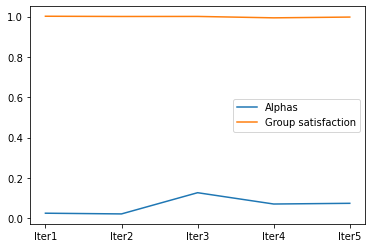

In [23]:
alphas = [alpha1, alpha2, alpha3, alpha4, alpha5]
#group_disL = [group_dis1, group_dis2, group_dis3, group_dis4, group_dis5]

#plt.plot(labels, group_disL)
plt.plot(labels, alphas)
plt.plot(labels, groupSatL)
plt.legend(["Alphas","Group satisfaction" ])
plt.show()

In [24]:
#overall satisfaction
userATotSat = np.sum(userASatL)
userBTotSat = np.sum(userBSatL)
userCTotSat = np.sum(userCSatL)

overalSat = (userATotSat + userBTotSat + userCTotSat)/5
print("Overall user satisfaction from 5 iteration ", overalSat)

Overall user satisfaction from 5 iteration  2.997470092847532
